<a href="https://colab.research.google.com/drive/1B9O2wxYXp6lgKjuaxG1J5JUTCxLX5ZI9?usp=sharing" target="blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Using Llama 3 for Building AI Agents


__Comprehensive guide to building AI Agents with Llama 3.1 function calling capabilities.__

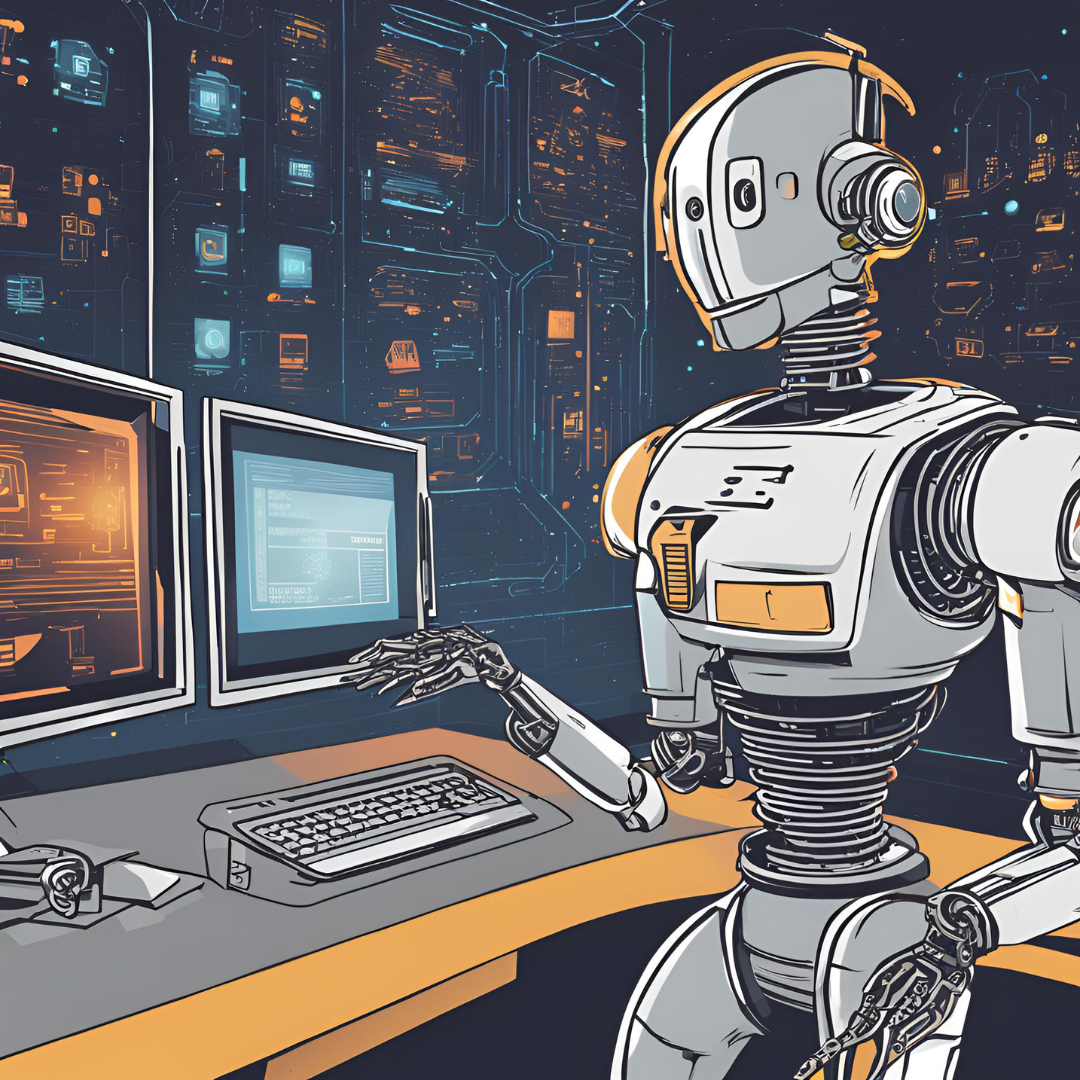

## Introduction

Imagine you want to buy something. You visit an e-commerce website and use the search option to find what you want. Maybe you have multiple items to buy, so the process isn’t very efficient. Now consider this scenario: open an application, describe what you want in plain English, and press enter. You don't have to worry about searching and price comparisons because the application handles it automatically for you. Pretty cool, right? That’s exactly what we’ll build in this tutorial.

Let’s look at some examples first.

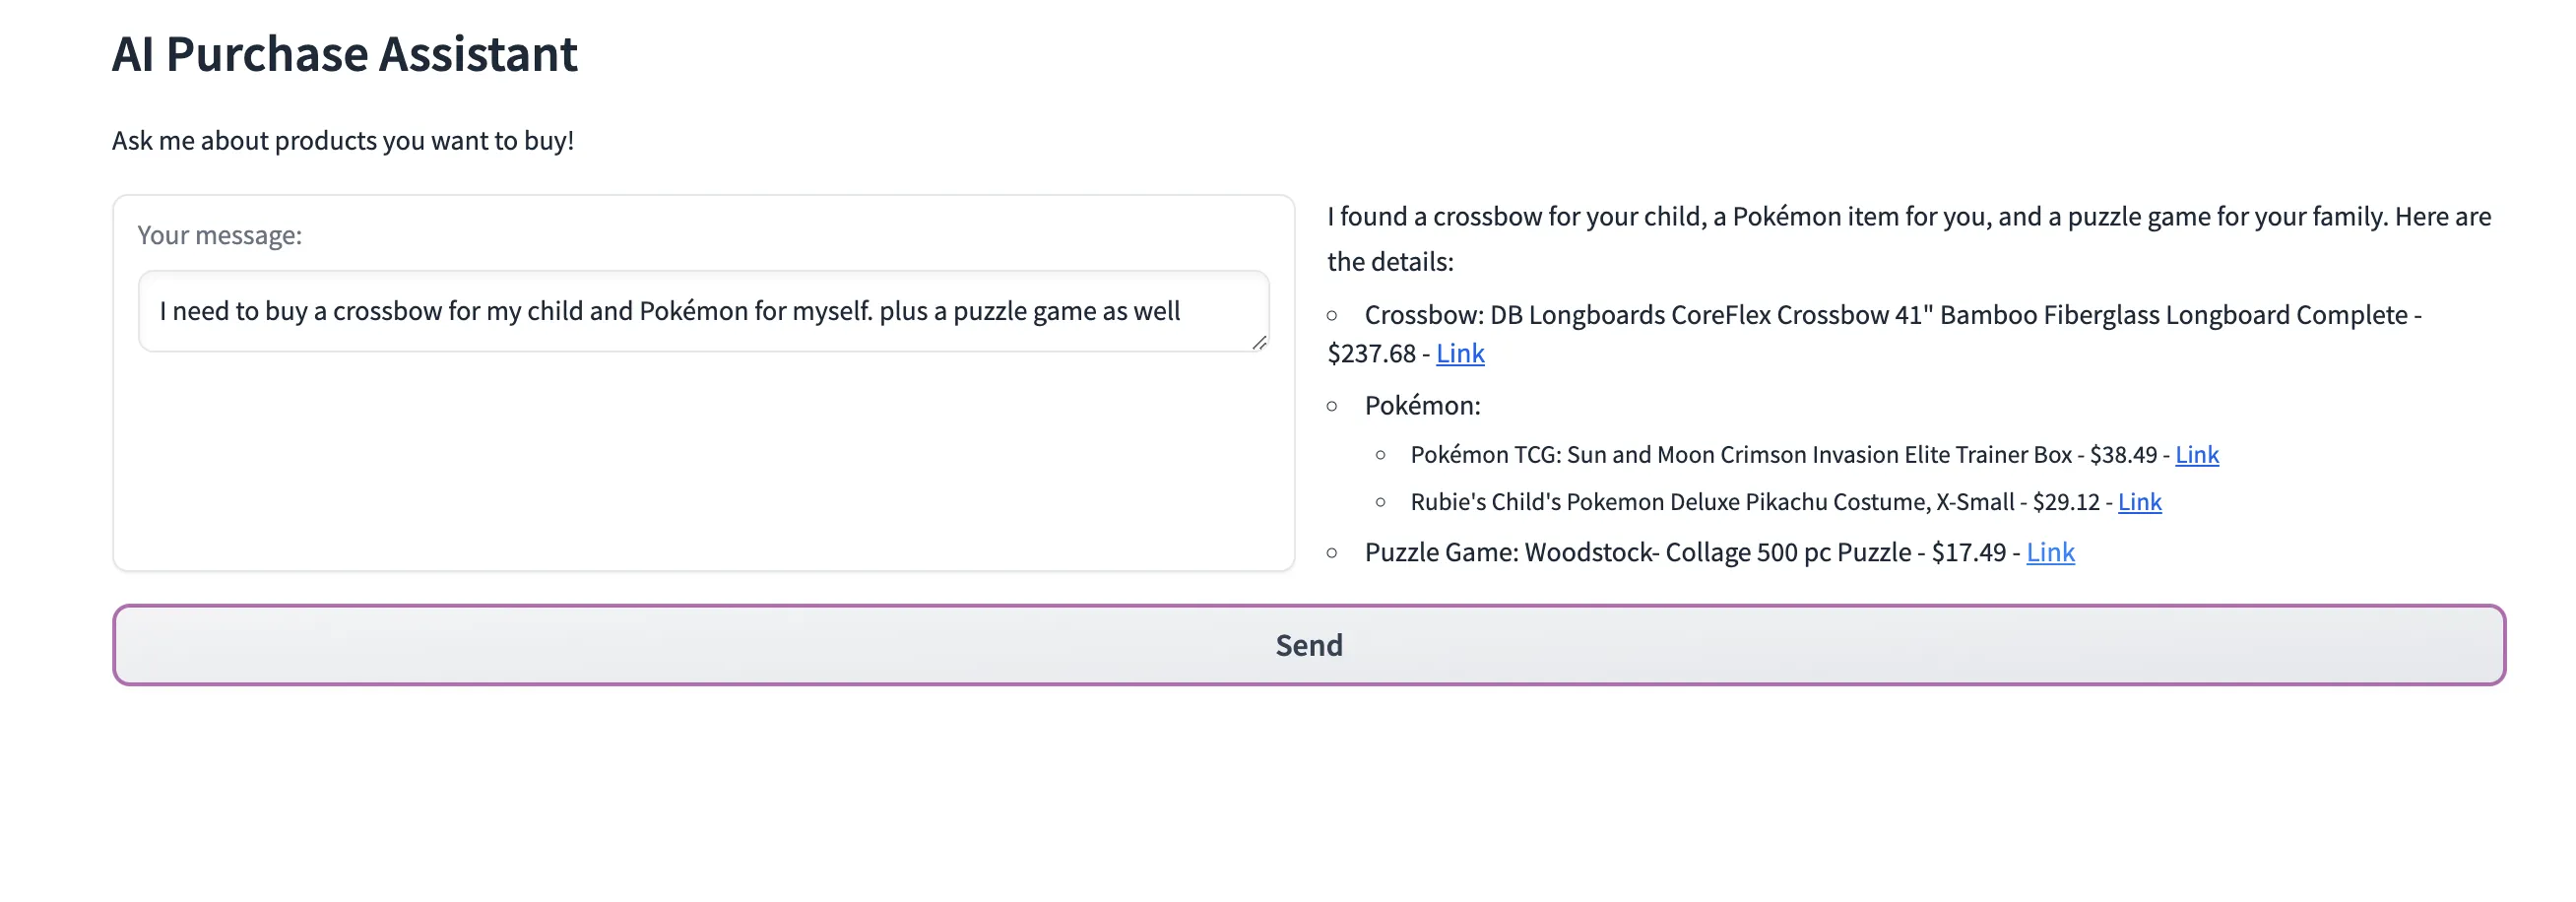

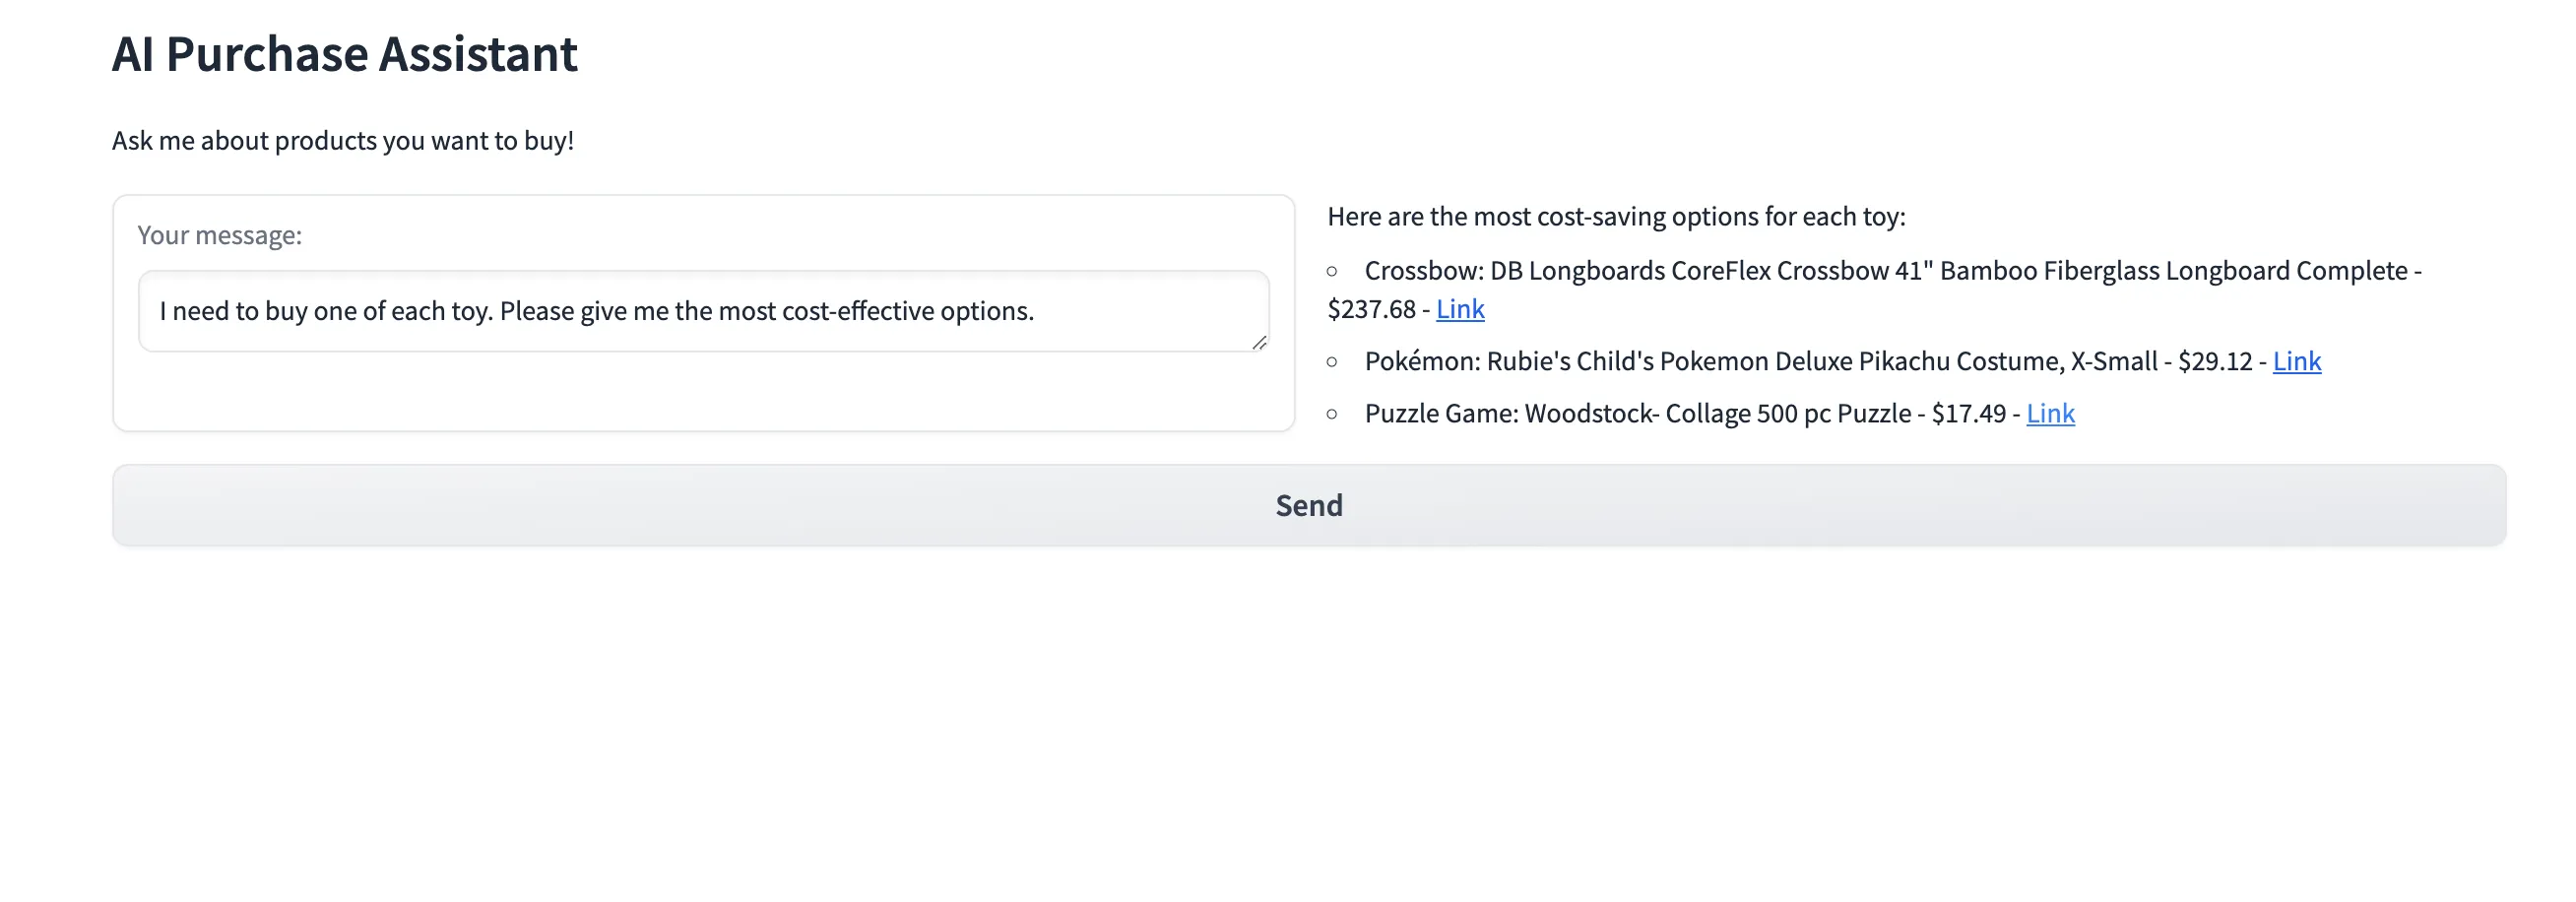

Alright, let’s bring life to this application. We’re going to use Meta’s Llama 3 model with function calling capability. However, this can also be accomplished using the 3.1 models. According to [Meta’s announcement](https://ai.meta.com/blog/meta-llama-3-1/), the 3.1 models can use tools and functions more effectively.

>These are multilingual and have a significantly longer context length of 128K, state-of-the-art tool use, and overall stronger reasoning capabilities

I will use Groq Cloud, specifically their model for this article. The initial workflow of this application should consist of an embedding model, a retriever, and two major tools for handling user purchase interests and cost-related concerns. In summary, we need something similar to what we've described in the diagram below.

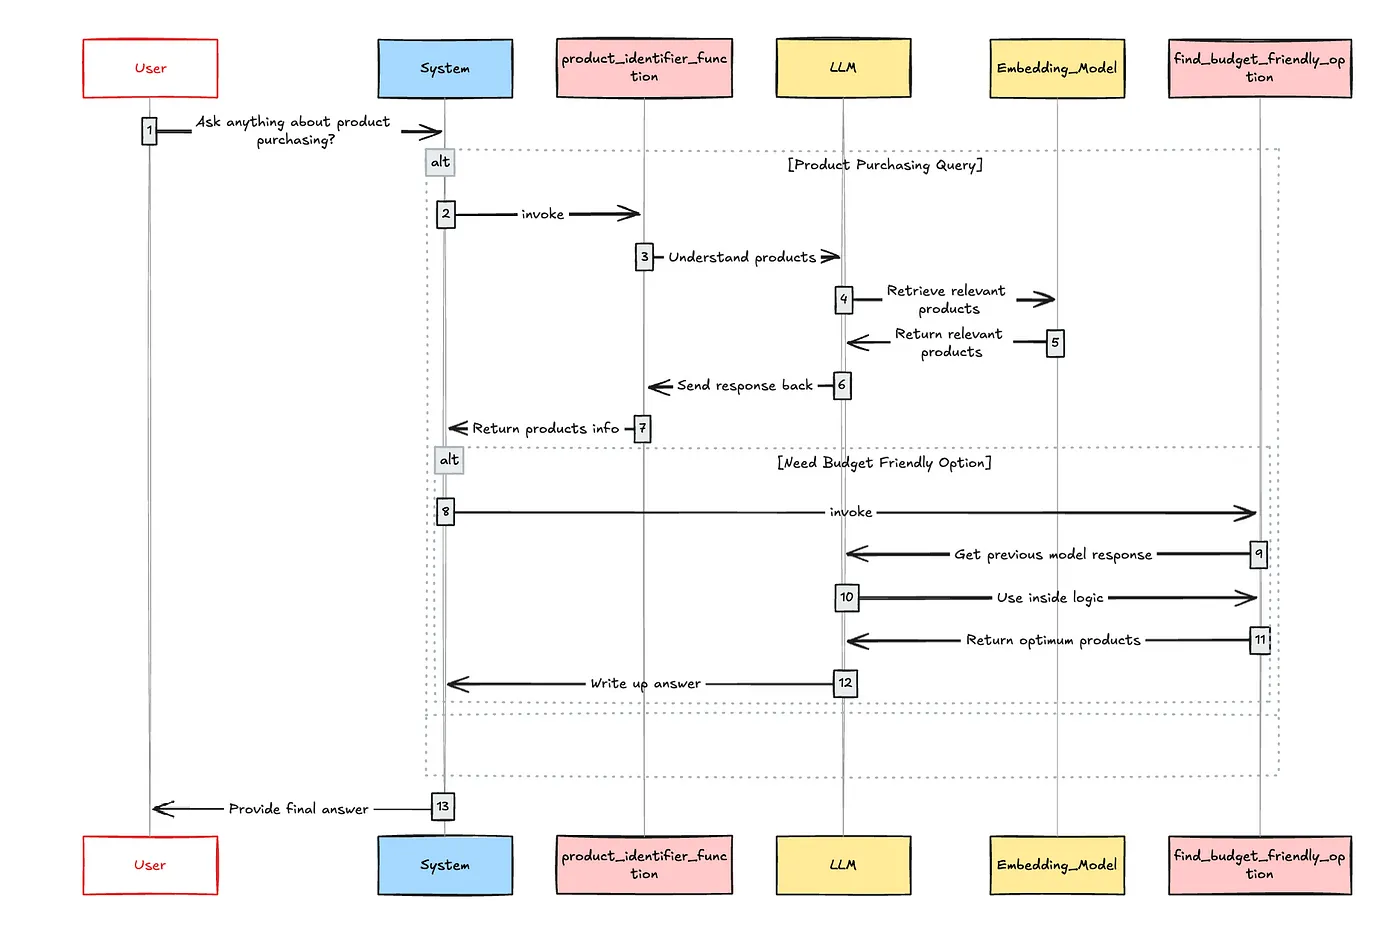

Now we have to use an LLM orchestration framework. For that, I am picking my all-time favorite, [Haystack](https://haystack.deepset.ai/).

Okay, we got what we need. Let’s jump into the actual work!

## Loading and Indexing data


Since we have an RAG pipeline, we should build a document indexing service as the first step. For this demo, I am going to use the in-memory vector database that Haystack offers. Please note that each document in our vector database contains,

- Content — Which we used to perform a similarity search
- Id — Unique identifier
- Price — Product price
- URL — Product URL

When our RAG pipeline is invoked, the Content field is used for vector search. All other fields are included as metadata. It’s crucial to preserve this metadata as it’s essential for front-end presentation to the user.

Let’s see how we can implement that.

In [2]:
%%capture
!pip install haystack-ai
!pip install "sentence-transformers>=2.2.0"
!pip install gradio

In [3]:
from dotenv import load_dotenv
import os
import re
from pprint import pprint
from ast import literal_eval
from typing import List
import json
import pandas as pd
from haystack import Pipeline, Document
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.writers import DocumentWriter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.generators import OpenAIGenerator
from haystack.utils import Secret
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.builders import PromptBuilder
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.dataclasses import ChatMessage

In [4]:
load_dotenv()

In [5]:
generator = lambda : OpenAIGenerator(
    api_key=Secret.from_env_var("GROQ_API_KEY"),
    api_base_url="https://api.groq.com/openai/v1",
    model="llama-3.1-70b-versatile",
    generation_kwargs = {"max_tokens": 512}
)

get_chat_generator = lambda **kwargs: OpenAIChatGenerator(
    api_key=Secret.from_env_var("GROQ_API_KEY"),
    api_base_url="https://api.groq.com/openai/v1",
    model="llama3-groq-70b-8192-tool-use-preview",
    generation_kwargs={"max_tokens": 512},
    **kwargs
)

## Load Dataset and Index

In [6]:
df = pd.read_csv("https://raw.githubusercontent.com/Ransaka/ai-agents-with-llama3/main/amazon_product_sample.csv")

document_store = InMemoryDocumentStore()
documents = [
    Document(
        content=item.product_name,
        meta={
            "id":item.uniq_id,
            "price":item.selling_price,
            "url":item.product_url
            }
        ) for item in df.head(10).itertuples()
    ]

indexing_pipeline = Pipeline()

indexing_pipeline.add_component(
    instance=SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2"), name="doc_embedder"
)

indexing_pipeline.add_component(instance=DocumentWriter(document_store= document_store), name="doc_writer")

indexing_pipeline.connect("doc_embedder.documents", "doc_writer.documents")

indexing_pipeline.run({"doc_embedder": {"documents": documents}})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:99: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'doc_writer': {'documents_written': 10}}

Great, we’ve completed the first step of our AI agent application. Now it’s time to build the product identifier tool. To better understand the primary task of the product identifier, let’s consider the example below.

>User Query: I want to buy a camping boot, a charcoal and google pixel 9 back cover. Let’s understand our ideal workflow for the product identifier function.

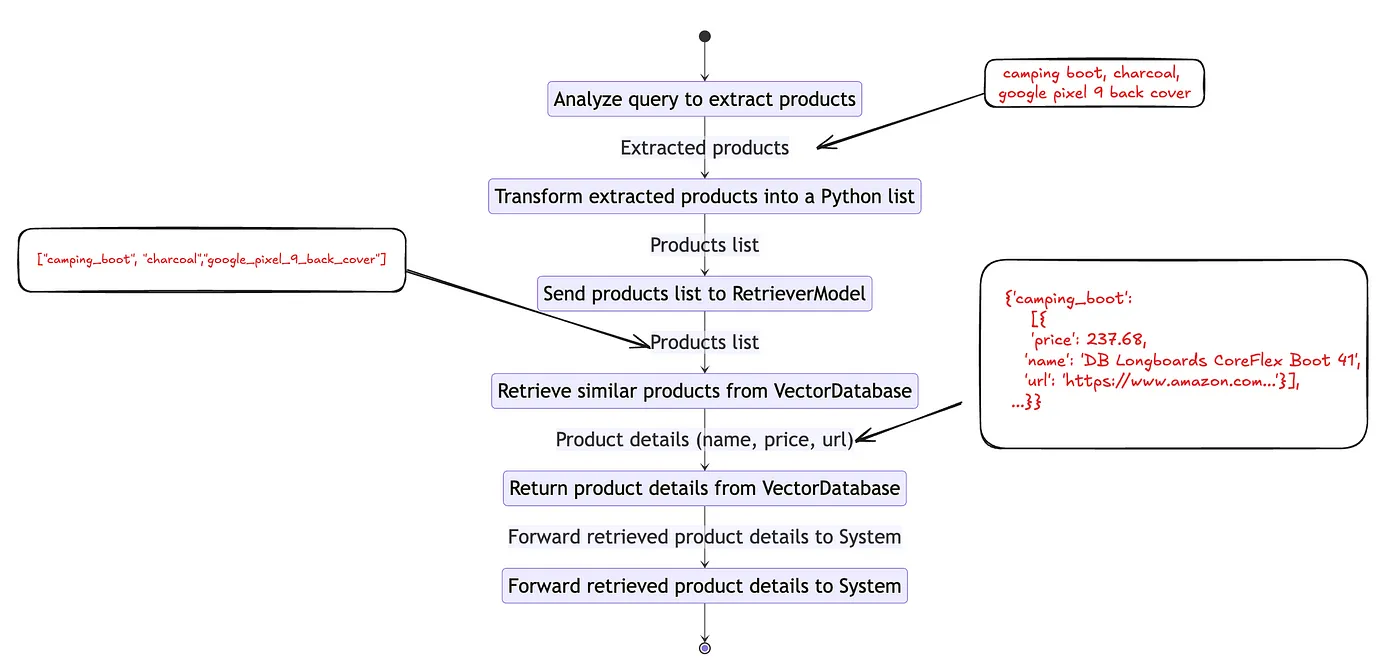

First, we need to create a tool for analyzing user queries and identifying user-interested products. We can build such a tool using code snippets below.

## Building User Query Analyzer

In [7]:
template = """
Understand the user query and list of products the user is interested in and return product names as list.
You should always return a Python list. Do not return any explanation.

Examples:
Question: I am interested in camping boots, charcoal and disposable rain jacket.
Answer: ["camping_boots","charcoal","disposable_rain_jacket"]

Question: Need a laptop, wireless mouse, and noise-cancelling headphones for work.
Answer: ["laptop","wireless_mouse","noise_cancelling_headphones"]

Question: {{ question }}
Answer:
"""

product_identifier = Pipeline()

product_identifier.add_component("prompt_builder", PromptBuilder(template=template))
product_identifier.add_component("llm", generator())

product_identifier.connect("prompt_builder", "llm")

🚅 Components
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - prompt_builder.prompt -> llm.prompt (str)

Okay, now we have completed half of our first function, now it’s time to complete the function by adding the RAG pipeline.

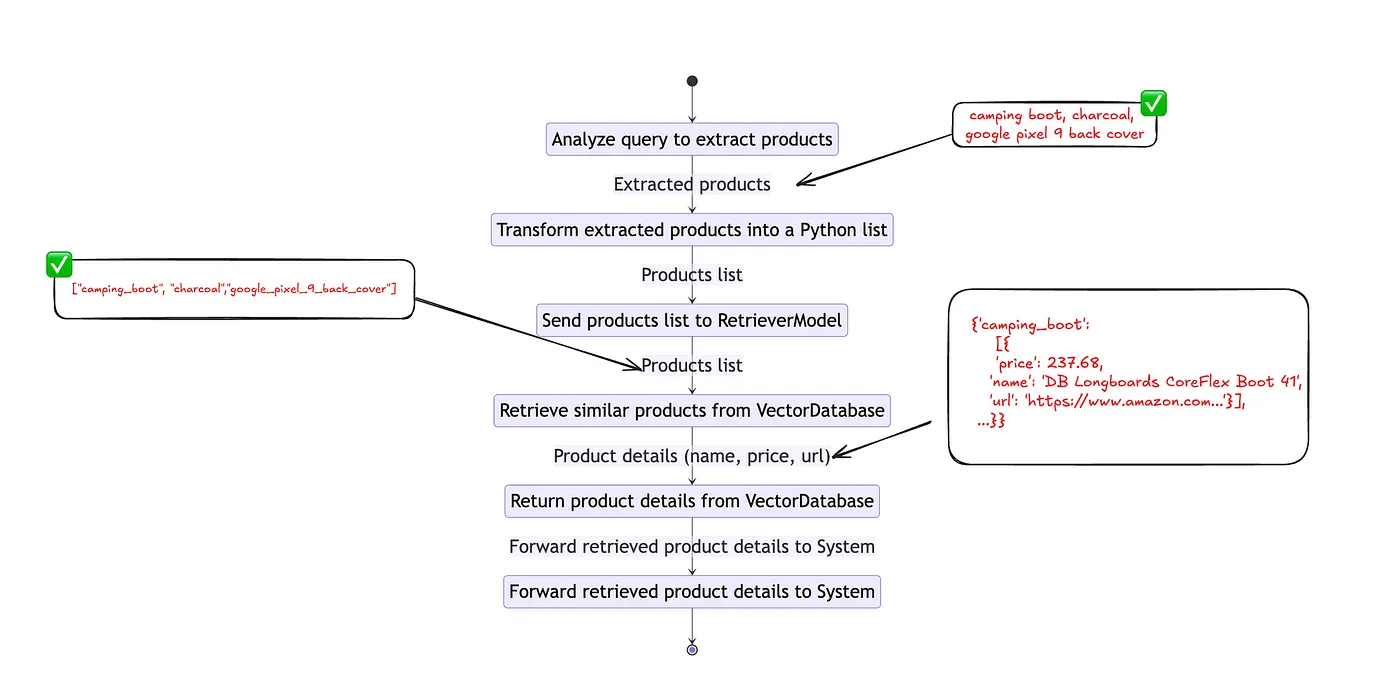

In [8]:
# testing product identifier tool
query = "I want crossbow and woodstock puzzle"
product_identifier.run({"prompt_builder": {"question": query}})

{'llm': {'replies': ['["crossbow","woodstock_puzzle"]'],
  'meta': [{'model': 'llama-3.1-70b-versatile',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 10,
     'prompt_tokens': 128,
     'total_tokens': 138,
     'prompt_time': 0.039384082,
     'completion_time': 0.04,
     'total_time': 0.079384082}}]}}

## Building RAG pipeline

In [9]:
template = """
Return product name, price, and url as a python dictionary.
You should always return a Python dictionary with keys price, name and url for single product.
You should always return a Python list of dictionaries with keys price, name and url for multiple products.
Do not return any explanation.

Legitimate Response Schema:
{"price": "float", "name": "string", "url": "string"}
Legitimate Response Schema for multiple products:
[{"price": "float", "name": "string", "url": "string"},{"price": "float", "name": "string", "url": "string"}]

Context:
{% for document in documents %}
    product_price: {{ document.meta['price'] }}
    product_url: {{ document.meta['url'] }}
    product_id: {{ document.meta['id'] }}
    product_name: {{ document.content }}
{% endfor %}
Question: {{ question }}
Answer:
"""

rag_pipe = Pipeline()
rag_pipe.add_component("embedder", SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2"))
rag_pipe.add_component("retriever", InMemoryEmbeddingRetriever(document_store=document_store, top_k=5))
rag_pipe.add_component("prompt_builder", PromptBuilder(template=template))
rag_pipe.add_component("llm", generator())

rag_pipe.connect("embedder.embedding", "retriever.query_embedding")
rag_pipe.connect("retriever", "prompt_builder.documents")
rag_pipe.connect("prompt_builder", "llm")

🚅 Components
  - embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

After this stage, we have completed both RAG and Query Analyzer pipelines. Now it’s time to convert this into a tool. For that, we can use a regular function declaration, as shown below. Creating a tool for the Agent is just like creating a Python function. In case you have a question like

How is it possible for the Agent to invoke this function?

The solution is straightforward: by leveraging a model-specific tool schema, which we plan to incorporate in a future step. For now, it’s time to create a wrapper function that uses both the query analyzer and RAG pipeline.

Let’s clarify the objectives of this function.

**Objective 1:** Identify all products the user is interested in and return them as a list.

**Objective 2:** For each identified product, retrieve up to five products from the database along with their metadata.

## Combining product identifier with RAG pipeline

In [10]:
def product_identifier_func(query: str):
    product_understanding = product_identifier.run({"prompt_builder": {"question": query}})

    try:
        product_list = literal_eval(product_understanding["llm"]["replies"][0])
    except:
        return "No product found"

    results = {}

    for product in product_list:
        response = rag_pipe.run({"embedder": {"text": product}, "prompt_builder": {"question": product}})
        try:
            results[product] = literal_eval(response["llm"]["replies"][0])
        except:
            results[product] = {}

    return results

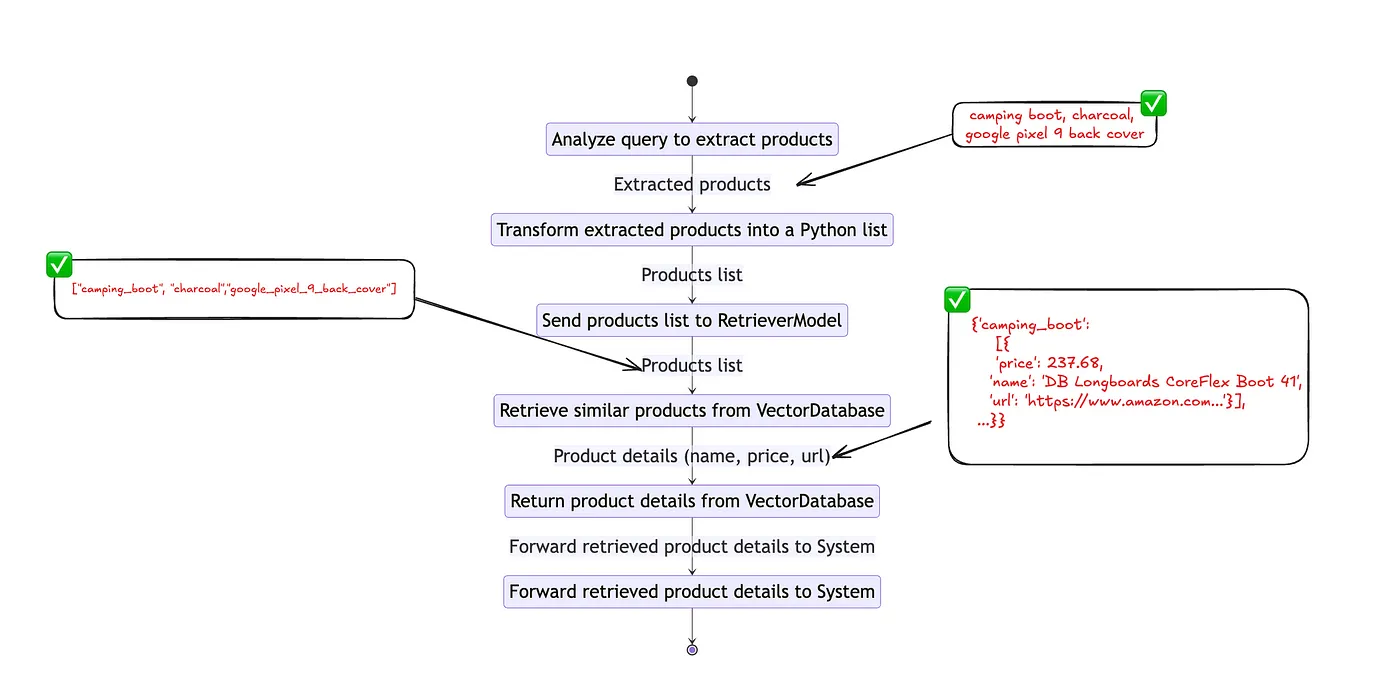

With that, we have completed our first tool for the agent. Let’s see whether it works as expected.

In [11]:
## Testing functions
product_identifier_func(query)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'crossbow': {},
 'woodstock_puzzle': {'price': 17.49,
  'name': 'Woodstock- Collage 500 pc Puzzle',
  'url': 'https://www.amazon.com/Woodstock-Collage-500-pc-Puzzle/dp/B07MX21WWX'}}

It worked!! However, it’s worth noting the return output schema. You can see the general schema below.

```python
{
    "product_key": {
        "name": "string",
        "price": "float",
        "url": "string"
    }
}
```

That’s exactly what we have advised the model to produce in the RAG pipeline. As a next step, let’s build an optional tool called find_budget_friendly_option.

In [12]:
def find_budget_friendly_option(selected_product_details):
    budget_friendly_options = {}

    for category, items in selected_product_details.items():
        if isinstance(items, list):
            lowest_price_item = min(items, key=lambda x: x['price'])
        else:
            lowest_price_item = items

        budget_friendly_options[category] = lowest_price_item

    return budget_friendly_options

Okay, let's focus on the most crucial aspect of this application, which is enabling the agent to use these functions as needed. As we previously talked about, this is achievable through a model-specific tool schema. Therefore, we need to locate the tool schema specific to the selected model. Fortunately, it's mentioned in the model card [here](https://huggingface.co/Groq/Llama-3-Groq-70B-Tool-Use). We need to adjust that to fit our use case.

In [13]:
product_identifier_func("I wat to purchase Pokemon for my kids, and crossbow for myself")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'Pokemon': [{'price': 38.49,
   'name': 'Pokemon TCG: Sun and Moon Crimson Invasion Elite Trainer Box',
   'url': 'https://www.amazon.com/Pokemon-TCG-Crimson-Invasion-Trainer/dp/B074NCGNX2'},
  {'price': 29.12,
   'name': "Rubie's Child's Pokemon Deluxe Pikachu Costume, X-Small",
   'url': 'https://www.amazon.com/Rubies-Deluxe-Pikachu-Pokemon-Costume/dp/B07BZJM592'}],
 'crossbow': {'price': 237.68,
  'name': 'DB Longboards CoreFlex Crossbow 41" Bamboo Fiberglass Longboard Complete',
  'url': 'https://www.amazon.com/DB-Longboards-CoreFlex-Fiberglass-Longboard/dp/B07KMVJJK7'}}

## Finalizing Chat Template

In [14]:
chat_template = '''<|start_header_id|>system<|end_header_id|>

You are a function calling AI model. You are provided with function signatures within <tools></tools> XML tags. You may call one or more functions to assist with the user query. Don't make assumptions about what values to plug into functions. For each function call return a json object with function name and arguments within <tool_call></tool_call> XML tags as follows:
<tool_call>
{"name": <function-name>,"arguments": <args-dict>}
</tool_call>

Here are the available tools:
<tools>
    {
        "name": "product_identifier_func",
        "description": "To understand user interested products and its details",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "string",
                    "description": "The query to use in the search. Infer this from the user's message. It should be a question or a statement"
                }
            },
            "required": ["query"]
        }
    },
    {
        "name": "find_budget_friendly_option",
        "description": "Get the most cost-friendly option. If selected_product_details has morethan one key this should return most cost-friendly options",
        "parameters": {
            "type": "object",
            "properties": {
                "selected_product_details": {
                    "type": "dict",
                    "description": "Input data is a dictionary where each key is a category name, and its value is either a single dictionary with 'price', 'name', and 'url' keys or a list of such dictionaries; example: {'category1': [{'price': 10.5, 'name': 'item1', 'url': 'http://example.com/item1'}, {'price': 8.99, 'name': 'item2', 'url': 'http://example.com/item2'}], 'category2': {'price': 15.0, 'name': 'item3', 'url': 'http://example.com/item3'}}"
                }
            },
            "required": ["selected_product_details"]
        }
    }
</tools><|eot_id|><|start_header_id|>user<|end_header_id|>

I need to buy a crossbow<|eot_id|><|start_header_id|>assistant<|end_header_id|>

<tool_call>
{"id":"call_deok","name":"product_identifier_func","arguments":{"query":"I need to buy a crossbow"}}
</tool_call><|eot_id|><|start_header_id|>tool<|end_header_id|>

<tool_response>
{"id":"call_deok","result":{'crossbow': {'price': 237.68,'name': 'crossbow','url': 'https://www.amazon.com/crossbow/dp/B07KMVJJK7'}}}
</tool_response><|eot_id|><|start_header_id|>assistant<|end_header_id|>
'''

Now there are only a few steps left. Before doing anything, let’s test our agent.

In [15]:
## Testing template
messages = [
    ChatMessage.from_system(
        chat_template
    ),
    ChatMessage.from_user("I need to buy a crossbow for my child and Pokémon for myself."),
]

chat_generator = get_chat_generator()
response = chat_generator.run(messages=messages)
pprint(response)

{'replies': [ChatMessage(content='<tool_call>\n'
                                 '{"id": 0, "name": "product_identifier_func", '
                                 '"arguments": {"query": "I need to buy a '
                                 'crossbow for my child"}}\n'
                                 '</tool_call>\n'
                                 '<tool_call>\n'
                                 '{"id": 1, "name": "product_identifier_func", '
                                 '"arguments": {"query": "I need to buy a '
                                 'crossbow for myself"}}\n'
                                 '</tool_call>',
                         role=<ChatRole.ASSISTANT: 'assistant'>,
                         name=None,
                         meta={'finish_reason': 'stop',
                               'index': 0,
                               'model': 'llama3-groq-70b-8192-tool-use-preview',
                               'usage': {'completion_time': 0.219675905,
             

With that, we have completed about 90% of our work.

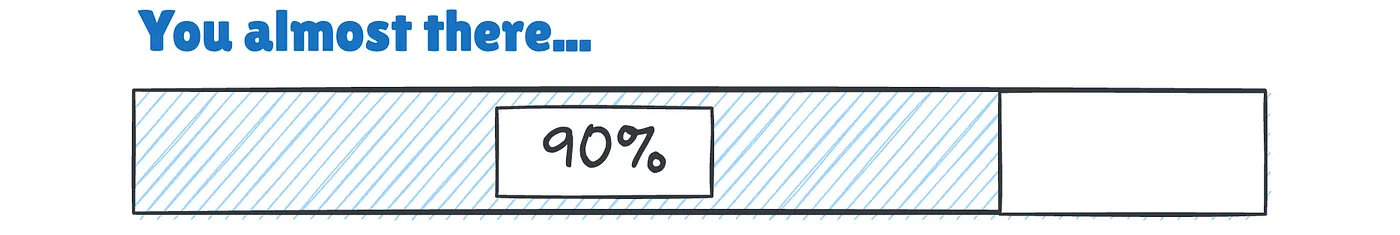

One thing you may have noticed in the above response is that the XML tag `<tool_call>` encloses tool calls. Thus, we need to develop a mechanism to extract the tool_call object.

In [16]:
## For extracting tool calls
def extract_tool_calls(tool_calls_str):
    json_objects = re.findall(r'<tool_call>(.*?)</tool_call>', tool_calls_str, re.DOTALL)

    result_list = [json.loads(obj) for obj in json_objects]

    return result_list

In [17]:
available_functions = {
    "product_identifier_func": product_identifier_func,
    "find_budget_friendly_option": find_budget_friendly_option
    }

With this step completed, we can directly access the agent’s response when it calls a tool. Now the only thing pending is to get the tool call object and execute the function accordingly. Let’s complete that piece too.

```python
messages.append(ChatMessage.from_user(message))
response = chat_generator.run(messages=messages)

if response and "<tool_call>" in response["replies"][0].content:
    function_calls = extract_tool_calls(response["replies"][0].content)
    for function_call in function_calls:
        # Parse function calling information
        function_name = function_call["name"]
        function_args = function_call["arguments"]

        # Find the corresponding function and call it with the given arguments
        function_to_call = available_functions[function_name]
        function_response = function_to_call(**function_args)

        # Append function response to the messages list using `ChatMessage.from_function`
        messages.append(ChatMessage.from_function(content=json.dumps(function_response), name=function_name))
        response = chat_generator.run(messages=messages)
```



Now it’s time to join each component together and build a proper chat application. I am going to use Gradio for that purpose.

In [18]:
import gradio as gr

messages = [ChatMessage.from_system(chat_template)]
chat_generator = get_chat_generator()

def chatbot_with_fc(message, messages):
    messages.append(ChatMessage.from_user(message))
    response = chat_generator.run(messages=messages)

    while True:
        if response and "<tool_call>" in response["replies"][0].content:
            function_calls = extract_tool_calls(response["replies"][0].content)
            for function_call in function_calls:
                # Parse function calling information
                function_name = function_call["name"]
                function_args = function_call["arguments"]

                # Find the corresponding function and call it with the given arguments
                function_to_call = available_functions[function_name]
                function_response = function_to_call(**function_args)

                # Append function response to the messages list using `ChatMessage.from_function`
                messages.append(ChatMessage.from_function(content=json.dumps(function_response), name=function_name))
                response = chat_generator.run(messages=messages)

        # Regular Conversation
        else:
            messages.append(response["replies"][0])
            break
    return response["replies"][0].content

# Define Gradio interface function
def chatbot_interface(user_input, state):
    response_content = chatbot_with_fc(user_input, state)
    return response_content, state

# Gradio app
with gr.Blocks() as demo:
    gr.Markdown("# AI Purchase Assistant")
    gr.Markdown("Ask me about products you want to buy!")

    state = gr.State(value=messages)

    with gr.Row():
        user_input = gr.Textbox(label="Your message:")
        response_output = gr.Markdown(label="Response:")

    user_input.submit(chatbot_interface, [user_input, state], [response_output, state])
    gr.Button("Send").click(chatbot_interface, [user_input, state], [response_output, state])


demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://e20b0bb842f3b3849c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


That’s it! We have built the Llama 3-based AI Agent 🤖 with function calling capability.

*Notebook by [Ransaka Ravihara](https://www.linkedin.com/in/ransaka/)*